# __**ML Models to Predict NYC taxi trip durations for yellow taxi rides in 2016**__
___
## Table of contents: <a name="0"></a>

## [1. Introduction](#1)
## [2. Elastic net regression on all the variables](#2)
## [3. Further Tuning XGBoost](#3)
## [4. Removing the flattening from RF output by increasing max_depth](#4)
___


# 1. Introduction <a name="1"></a>

If you are looking for detailed NYC ML modeling work for the NYC taxi trip prediction please refer to the NYC_ML notebook in the same folder as this notebook. This notebook was developed for experimentation purposes. We will see if the models developed in the NYC_ML notebook can be made better by including more variables (Elastic net), increasing numebr of trees or max_depth (RF) or by more hyperparameter tuning (XGBoost).

## Importing libraries

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import scipy.stats
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [10, 5]
import random
import geopandas
from shapely.geometry import Point

import time
import pathlib

import sklearn.preprocessing
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split

import sys
import importlib
sys.path.append('../NYC')
#%load_ext autoreload (if you need to edit the module while working on this notebook)
import data_preprocess 
import nyc_ml_err_plots 
import nyc_ml_models

importlib.reload(data_preprocess)
importlib.reload(nyc_ml_err_plots)
importlib.reload(nyc_ml_models)
#print(dir(data_prep))

<module 'nyc_ml_models' from '../NYC\\nyc_ml_models.py'>

In [92]:
import plot_figs
importlib.reload(plot_figs)

<module 'plot_figs' from '../NYC\\plot_figs.py'>

In [2]:
nyc_4_loc = '../data/interim/4_nyc_EDA.csv'
df = pd.read_csv(nyc_4_loc, parse_dates = ['pickup_datetime', 'dropoff_datetime'])

In [3]:
df['pickup_weekday'] = df.pickup_datetime.dt.dayofweek

In [4]:
tp_df = df.sample(200000, random_state = 42).reset_index(drop = True)

In [5]:
cols_to = ['vendorid', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
              'pickup_month', 'pickup_day', 'pickup_hour', 'pickup_weekday',
              'holiday', 'distance_hav', 'bearing', 'pickup_zone_cluster', 'dropoff_zone_cluster',
              'trip_duration']

# 2. Elastic net regression on all the variables <a name="2"></a>

In the original NYC_ML notebook, I hadn't used all the variables to train the Elastic Net regression (ENR) model because of many variables neing non-linear and categorical. One way to handle that problem is converting the non-linear and categorical variables into something useful that the linear regression model can understand. 

* bearing
For example, the bearing direction ranges from 0 degrees to 359 degrees but we can pass this variable to the ENR model as it is because if we do that the model will treat it as an increasing variable where 359 is farthest from 0, which is not the case. In fact, 359 and 0 are very close on the polar coordinates. We can handle this either by using some sine and cosine function to represent the points in the polar coordinate system or simply create direction bins such as "North", "North East", etc. 
Here, I have divided the 0 to 360 range into 8 bins - N, NE, E, SE, S, SW, W, NW, thus each bin is 45 degrees wide. 

* pickup and dropoff clusters
Pickup and dropoff clusters are another set of variables that need extra handling. The clusters are randomly numbered and they don't follow any particular order. So, I have used One hot encoidng here to create 49 (N-1) variables each for pickup and dropoff cluster columns. For example, if for a row, pickup_cluster is 38, then only the pickup_cluster_38 column will have 1 and rest of the pikcup_cluster_XX columns will have a 0. Same for the dropoff_cluster variabkles. 

The bearing column with the string directions was also one hot encoded creating 7 (N-1) extra columns. In total, 118 columns were fed into the ENR model. Let's see if the performance improves. 

I haven't delved deep into handling categorical variables here, so, if you want more details on how to handle cat variables please refer to - > [How to deal with categorical variables](https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02)

In [172]:
def direction_NESW(x):
    """
    Function takes in the bearing direction variable (x) and returns the string direction N, NE, E, SE, S, SW, W or NW 
    depending on the direction on circular scale.
    """
    if x>360-22.5 or x <= 0+22.5:
        return "N"
    elif x > 0+22.5 and x<=45+22.5:
        return "NE"
    elif x>45+22.5 and x<=90+22.5:
        return "E"
    elif x>90+22.5 and x<=135+22.5:
        return "SE"
    elif x>135+22.5 and x<=180+22.5:
        return "S"
    elif x>180+22.5 and x<=225+22.5:
        return "SW"
    elif x>225+22.5 and x<=270+22.5:
        return "W"
    elif x>270+22.5 and x<=315+22.5:
        return "NW"

In [173]:
#Creating the direction string column
tp_df['bearing_NESW'] = tp_df['bearing'].apply(lambda x: direction_NESW(x))

In [176]:
tp_df[['bearing_NESW', 'bearing']].head(3)

,bearing_NESW,bearing
0,N,20.352126
1,NW,310.858870
2,S,198.444873


In [215]:
ENLR_df = tp_df.copy()

In [216]:
# One hot encoding the categorical variables
ENLR_df = pd.get_dummies(ENLR_df, prefix = ["pickup_cluster", "dropoff_cluster", "direction"], 
                         columns = ['pickup_zone_cluster', 'dropoff_zone_cluster', 'bearing_NESW'], drop_first=True)

In [217]:
# Selecting the variables for ENR model
cols_to_ENLR = [col for col in ENLR_df.columns if col not in ['vendorid','pickup_date', 'pickup_datetime', 'dropoff_datetime',
                                                              'pickup_zone_cluster', 'dropoff_zone_cluster', 'bearing', 
                                                               'store_and_fwd_flag', 'speed_mph', 'trip_bins_minutes',
                                                                '__label', 'pickup_taxizone_id', 'dropoff_taxizone_id',
                                                                'pickup_borough', 'dropoff_borough', 'trip_bins_speed',
                                                                 'bearing']]

In [223]:
# Tuning and fitting the model
params_LR = {'l1_ratio' : np.linspace(0, 1, 30),
                  'alpha' : np.logspace(-2, 0, 30)
                 }

ENLR_reg = ElasticNet()

C:\Users\ppawar\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.5min finished





============================= ElasticNet =================================

It takes 345.193 seconds for tuning 
BEST PARAMS {'l1_ratio': 1.0, 'alpha': 0.041753189365604}
It takes 13.337 seconds for fitting
train score:  0.6840626861661425  
test score:  0.6866256720887285

Error metrics for model Tuned Elastic Net w/ all variables (ohe)
RMSE or Root mean squared error: 358.34
RMSLE or Root mean squared log error: 0.46
Variance score: 0.69
Mean Absolute Error: 245.90
Mean Absolute Percentage Error: 42.08 %

Plotting Predicted vs Observed trip duration in seconds

Plotting Predicted vs Residuals


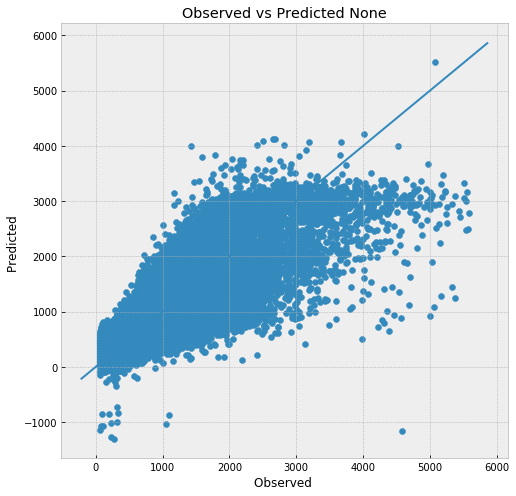

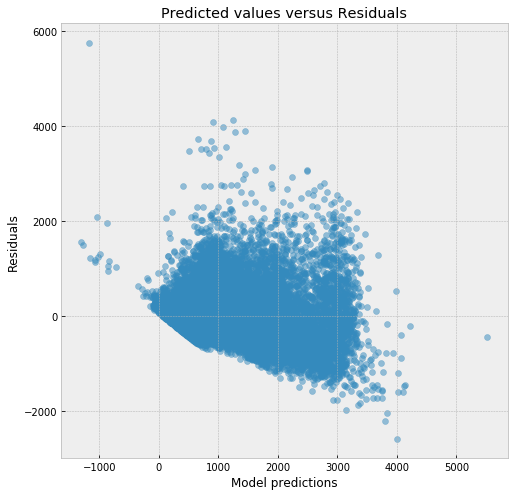

In [224]:
# We will use Standard Scaler to scale the X variables
model_ENLR, X_train_enlr, y_train_enlr, X_test_enlr, y_test_enlr = nyc_ml_models.do_regression(ENLR_reg, params_LR, 
                                                        ENLR_df[cols_to_ENLR], dict_err,
                                                        model_name = "Tuned Elastic Net w/ all variables (ohe)", 
                                                        test_size = 0.3, fourier = True, scale = True)

All the error metrics (RMSE, RMSLE, MAE, R2 score, MAPE) have improved as compared to the basic Elastic net model we had used in the NYC_ML notebook but the performance is still not as good as RF or XGBoost.

Maybe we can try encoding the categorical variables differently and see if that improves the performance but I will leave that as a future project.

# 3. Further Tuning XGBoost <a name="3"></a>

In [47]:
# generating the model
xg_regression = xgb.XGBRegressor(subsample = 0.8, 
                                 reg_alpha = 0.005, 
                                 n_estimators = 246, 
                                 min_child_weight =  3,
                                 max_depth = 6, 
                                 learning_rate = 0.1, 
                                 gamma =  0.0, 
                                 colsample_bytree =  1,
                                 eval_metric = 'rmse',
                                 objective = 'reg:squarederror')

params_xg = {
                    'n_estimators': [int(x) for x in np.linspace(100, 300, 30, endpoint = False)],
                    'learning_rate': [0.05, 0.075, 0.09, 0.1, 0.125, 0.15, 0.2],
                    'subsample': [0.76, 0.78, 0.8, 0.82, 0.84]
                    }

In [48]:
dict_err = {}

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.5min finished
C:\Users\ppawar\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \





============================= XGBRegressor =================================

It takes 656.314 seconds for tuning 
BEST PARAMS {'subsample': 0.84, 'n_estimators': 286, 'learning_rate': 0.2}
It takes 73.288 seconds for fitting
train score:  0.8683959817600826  
test score:  0.8174124144727896

Error metrics for model Tuned XGBoost
RMSE or Root mean squared error: 273.52
RMSLE or Root mean squared log error: 0.33
Variance score: 0.82
Mean Absolute Error: 178.70
Mean Absolute Percentage Error: 26.45 %

Plotting Predicted vs Observed trip duration in seconds

Plotting Predicted vs Residuals

Plotting feature importance


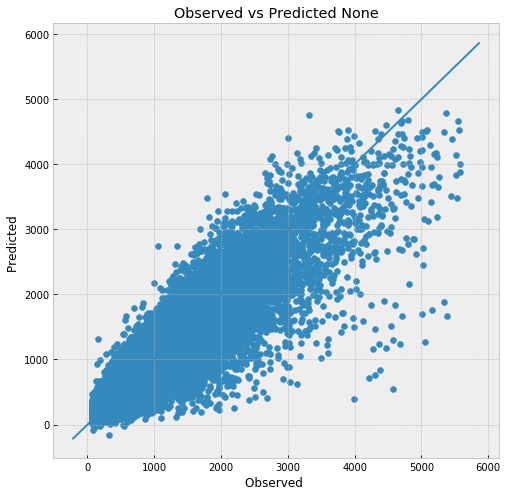

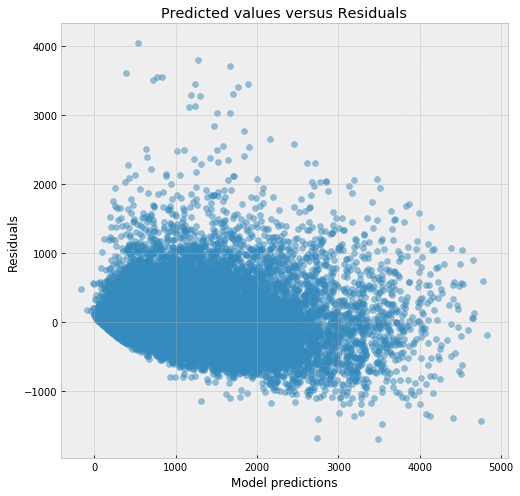

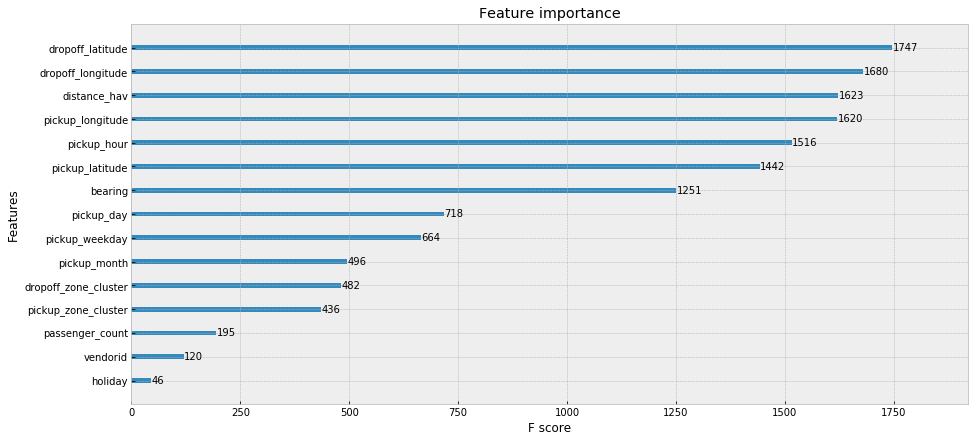

In [49]:
model_reg, X_train_x, y_train_x, X_test_x, y_test_x = nyc_ml_models.do_regression(xg_regression, params_xg, 
                                                        tp_df[cols_to], dict_err,
                                                        model_name = "Tuned XGBoost", test_size = 0.3, fourier = False)

Even after further tuning, the performance of the XGboost model remains more or less the same. Maybe next time we can try to include more number of rows and use GridSearcCV instead. But you shouldn't expect the performance to increase a lot from here.

# 4. Removing the flattening from RF output by increasing max_depth <a name="4"></a>

In the NYC_ML notebook we observed that the predictions for the RF model were getting capped at some higher and lower y-values and we had assumed that this is due to the trees being limited by the max_depth of 7. So, let's check if our assumption was right and increaase the max_depth while using the best parameters found in the NYC_ML notebook.

In [64]:
params_rf = {
                  'max_depth' : list(range(7, 18)),
                  'n_estimators': [int(x) for x in np.linspace(350, 450, 30, endpoint=False)]
                 }

rf_reg = RandomForestRegressor()

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 45.5min finished





============================= RandomForestRegressor =================================

It takes 3177.327 seconds for tuning 
BEST PARAMS {'n_estimators': 403, 'max_depth': 17}
It takes 445.885 seconds for fitting
train score:  0.9253150013411334  
test score:  0.7996550586528488

Error metrics for model Tuned RF reg
RMSE or Root mean squared error: 286.52
RMSLE or Root mean squared log error: 0.34
Variance score: 0.80
Mean Absolute Error: 189.02
Mean Absolute Percentage Error: 28.93 %

Plotting Predicted vs Observed trip duration in seconds

Plotting Predicted vs Residuals

Plotting feature importance


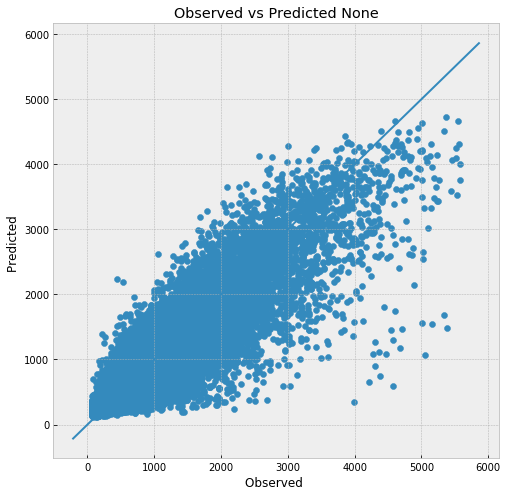

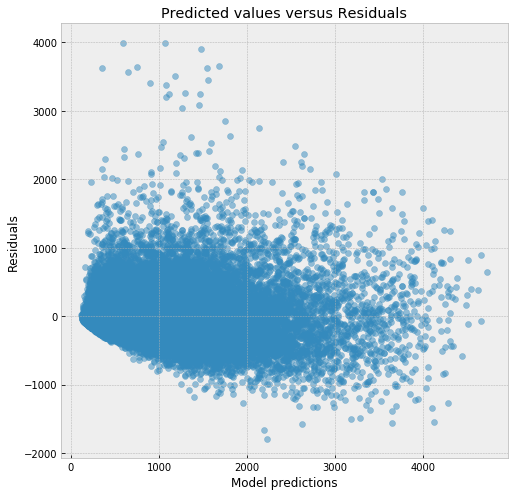

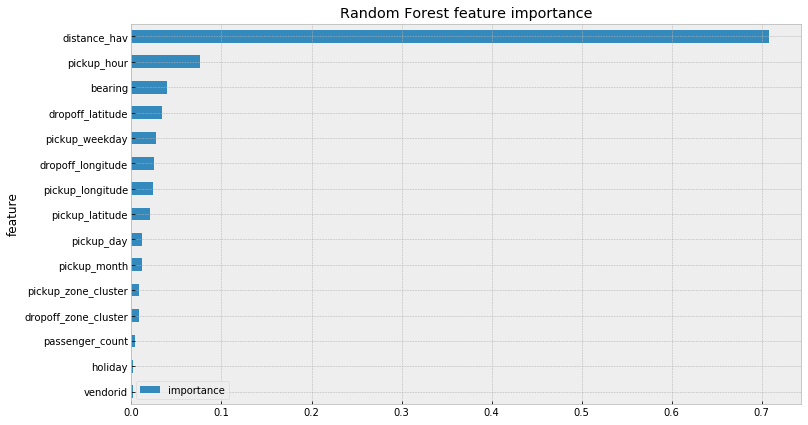

In [65]:
modelrf, X_trainrf, y_trainrf, X_testrf, y_testrf = nyc_ml_models.do_regression(rf_reg, params_rf, 
                                                                                tp_df[cols_to], dict_err,
                                                        model_name = "Tuned RF reg", test_size = 0.3, fourier = False)

* As expected, as we allow the trees to grow in depth, the leaf values are able to capture a larger range of the y variable because now each leaf is averaging over a small range as compared to the leaves at smaller depths. But, again as expected, this results in overfitting as you can see the difference in training R2 score and test R2 score is pretty significant. That's why in real world scenarios, usually the max_depth parameter used falls in the range of 3 to 8. 

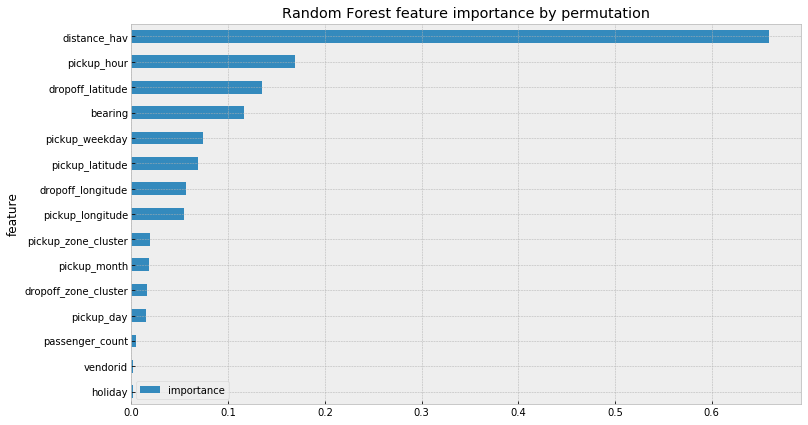

In [231]:
feat_imp_permut(modelrf,  X_trainrf, y_trainrf, model_name = "Random Forest")

## Comparing models

In [228]:
round(pd.DataFrame(dict_err) , 2).sort_values('RMSLE').set_index('model')

,train_test,RMSE,RMSLE,R2,MAE,MAPE
model,,,,,,
Tuned XGBoost,test,273.52,0.33,0.82,178.70,26.45
Tuned RF reg,test,286.52,0.34,0.80,189.02,28.93
Gradient Boosting Regressor,test,314.12,0.37,0.76,207.21,31.60
Tuned Elastic Net w/ all variables (ohe),test,358.84,0.45,0.69,246.24,42.22
Tuned Elastic Net w/ all variables (ohe),test,358.34,0.46,0.69,245.90,42.08


Note: 

* The above comparison chart includes a Gradient Boosting regressor which was just tuned on the number of trees and the output and the code were deleted later due to lower performance than XGboost.
* Tuned Elastic Net has two rows as one row (2nd last) represents the case when the X variables were scaled using Standard Scaler and the last row represents the case when they weren't scaled.

# Saving the ML models

In [66]:
import pickle

In [68]:
filename = 'trained_models/tuned_xgboost_2.sav'
pickle.dump(model_reg, open(filename, 'wb'))

In [69]:
# how to load the model again
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test_x, y_test_x)
print(result)

0.8174124144727896


In [71]:
filename_RF = 'trained_models/max_depth_RF_2.sav'
pickle.dump(rf_reg, open(filename_RF, 'wb'))

In [229]:
filename_ENR = 'trained_models/tuned_ENLR(ohe, all variables)_2.sav'
pickle.dump(model_ENLR, open(filename_ENR, 'wb'))